# Zespół asystentów badacza

W tym notatniku stworzymy zespół ekspertów, którzy pomogą nam rozwiązać problem.

To nasz najbardziej zaawansowany projekt, integrujący wszystkie przedstawione dotąd idee, a przy okazji praktyczny i o dużym potencjale dalszego rozwoju.

## Setup

In [ ]:
from dotenv import load_dotenv
load_dotenv()

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Zespół asystentów

Zaczniemy od funkcji umożliwiającej stworzenie zespołu analityków wspomagających nas w rozwiązaniu problemu.

Dodamy też możliwość zaopiniowania tego zespołu ("Human-in-the-loop").

In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Firma/organizacja, w której zatrudniony jest analityk.",
    )
    name: str = Field(
        description="Imię i nazwisko analityka."
    )
    role: str = Field(
        description="Rola analityka w projekcie, uwzględniająca jego (projektu) tematykę.",
    )
    description: str = Field(
        description="Obszary kompetencyjne, doświadczenie i motywacja analityka.",
    )

    # Dobrze dać mu persone by model sie biasował na to, że jest to faktyczna osoba z faktycznym doświadczeniem
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Wyczerpująca lista analityków wraz z ich rolami i organizacjami, dla których pracują.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Temat badania
    max_analysts: int # Liczba analityków
    human_analyst_feedback: str # Opinia użytkownika
    analysts: List[Analyst] # Analitycy zadający pytania narzędziom

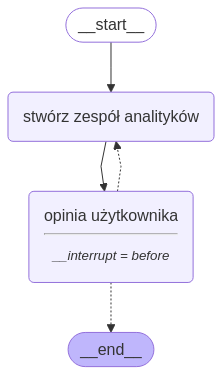

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# W przypadku promptu warto było by mieć coś co weryfikuje, że ten prompt nie przekracza kontekstu modelu
analyst_instructions="""Twoim zadaniem jest stworzenie zestawu person analityków biznesowych. Postępuj zgodnie z poniższymi instrukcjami:

1. Najpierw zapoznaj się z tematem badania:
{topic}

2. Przeanalizuj wszelkie opinie i wskazówki, które zostały opcjonalnie dostarczone w celu usprawnienia procesu  tworzenia zespołu analityków:

{human_analyst_feedback}

3. Stwórz listę najbardziej interesujących tematów w oparciu o powyższe dokumenty i/lub informacje zwrotne.

4. Wybierz maksimum {max_analysts} tematów.

5. Przypisz jednego analityka do każdego z tematów."""

# To jest bardziej assign analyst
def create_analysts(state: GenerateAnalystsState):

    """ Stwórz analityka"""
    print("... Tworzę zespół analityków ...")
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)


    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Stwórz zespół analityków.")])

    # Zapisz listę analityków do stanu
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "stwórz zespół analityków"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("stwórz zespół analityków", create_analysts)
builder.add_node("opinia użytkownika", human_feedback)
builder.add_edge(START, "stwórz zespół analityków")
builder.add_edge("stwórz zespół analityków", "opinia użytkownika")
builder.add_conditional_edges("opinia użytkownika", should_continue, ["stwórz zespół analityków", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['opinia użytkownika'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [5]:
# Input
max_analysts = 3
topic = "Jaki jest potencjał zastosowań systemów wielo-agentowych opartych na dużych modelach językowych w bankowości?"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

... Tworzę zespół analityków ...
Name: Anna Kowalska
Affiliation: Bank XYZ
Role: Ekspert ds. analizy danych
Description: Specjalizuje się w analizie danych finansowych oraz zastosowaniach sztucznej inteligencji w bankowości. Posiada doświadczenie w projektach związanych z automatyzacją procesów bankowych i optymalizacją usług.
--------------------------------------------------
Name: Marek Nowak
Affiliation: Instytut Badań Ekonomicznych
Role: Analityk trendów rynkowych
Description: Zajmuje się badaniem trendów w sektorze finansowym oraz wpływem nowych technologii na bankowość. Ma doświadczenie w pracy z modelami predykcyjnymi i analizą ryzyka.
--------------------------------------------------
Name: Katarzyna Wiśniewska
Affiliation: Firma Technologiczna ABC
Role: Specjalista ds. systemów wielo-agentowych
Description: Ekspert w dziedzinie systemów wielo-agentowych i ich zastosowań w różnych branżach, w tym bankowości. Posiada doświadczenie w projektowaniu i wdrażaniu rozwiązań opartych n

In [6]:
# Dodajmy teraz naszą opinię
opinia = "Dodaj eksperta w obszarze ochrony danych osobowych"
graph.update_state(thread, {"human_analyst_feedback":
                            opinia}, as_node="opinia użytkownika")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01f654-85b9-61b1-8002-64ac61c01626'}}

In [7]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Imię i nazwisko: {analyst.name}")
            print(f"Afiliacja: {analyst.affiliation}")
            print(f"Rola: {analyst.role}")
            print(f"Opis: {analyst.description}")
            print("-" * 50)

Imię i nazwisko: Anna Kowalska
Afiliacja: Bank XYZ
Rola: Ekspert ds. analizy danych
Opis: Specjalizuje się w analizie danych finansowych oraz zastosowaniach sztucznej inteligencji w bankowości. Posiada doświadczenie w projektach związanych z automatyzacją procesów bankowych i optymalizacją usług.
--------------------------------------------------
Imię i nazwisko: Marek Nowak
Afiliacja: Instytut Badań Ekonomicznych
Rola: Analityk trendów rynkowych
Opis: Zajmuje się badaniem trendów w sektorze finansowym oraz wpływem nowych technologii na bankowość. Ma doświadczenie w pracy z modelami predykcyjnymi i analizą ryzyka.
--------------------------------------------------
Imię i nazwisko: Katarzyna Wiśniewska
Afiliacja: Firma Technologiczna ABC
Rola: Specjalista ds. systemów wielo-agentowych
Opis: Ekspert w dziedzinie systemów wielo-agentowych i ich zastosowań w różnych branżach, w tym bankowości. Posiada doświadczenie w projektowaniu i wdrażaniu rozwiązań opartych na dużych modelach językowyc

In [8]:
# Jeśli nam to odpowiada, jako kolejną opinię dodajmy None
kolejna_opinia = None
graph.update_state(thread, {"human_analyst_feedback":
                            kolejna_opinia}, as_node="opinia użytkownika")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01f654-c78e-6e93-8004-ec02462a2797'}}

In [9]:
# Kontynuujmy wykonanie grafu
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [10]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [11]:
for analyst in analysts:
    print(f"Imię i nazwisko: {analyst.name}")
    print(f"Afiliacja: {analyst.affiliation}")
    print(f"Rola: {analyst.role}")
    print(f"Opis: {analyst.description}")
    print("-" * 50)

Imię i nazwisko: Anna Kowalska
Afiliacja: Bank XYZ
Rola: Ekspert ds. zastosowań systemów wielo-agentowych
Opis: Specjalizuje się w implementacji systemów opartych na sztucznej inteligencji w sektorze finansowym. Posiada doświadczenie w projektach związanych z automatyzacją procesów bankowych oraz analizą danych.
--------------------------------------------------
Imię i nazwisko: Marek Nowak
Afiliacja: Instytut Ochrony Danych
Rola: Ekspert ds. ochrony danych osobowych
Opis: Zajmuje się regulacjami prawnymi dotyczącymi ochrony danych osobowych w kontekście technologii AI. Posiada doświadczenie w audytach zgodności oraz wdrażaniu polityk ochrony danych w instytucjach finansowych.
--------------------------------------------------
Imię i nazwisko: Katarzyna Wiśniewska
Afiliacja: Uniwersytet Ekonomiczny
Rola: Analityk trendów rynkowych
Opis: Specjalizuje się w analizie trendów rynkowych i innowacji w bankowości. Posiada doświadczenie w badaniach nad wpływem nowych technologii na sektor fina

## Realizacja badań

Każdy z analityków będzie prowadził badania zadając odpowiednie swoim "narzędziom".

Zacznijmy więc od zaprojektowania funkcji generującej takie pytania.

In [12]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Maksymalna liczba zadanych pytań (iteracji)
    context: Annotated[list, operator.add] # Dokumenty źródłowe
    analyst: Analyst # Analityk zadający pytanie
    interview: str # Zapis "wywiadu"
    sections: list # Lista tematów, których realizację później zrównoleglimy

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Pytanie badawcze, kwerenda wyszukiwania.")

In [13]:
question_instructions = """Jesteś analitykiem, którego zadaniem jest przeprowadzenie wywiadu z ekspertem w celu uzyskania informacji na określony temat.

Twoim celem jest sprowadzenie się do interesujących i konkretnych spostrzeżeń związanych z tematem.

1. Interesujące: Spostrzeżenia, które ludzie uznają za zaskakujące lub nieoczywiste.

2. Konkretne: spostrzeżenia, które unikają ogólników i zawierają konkretne przykłady od eksperta.

Oto temat, na którym się skupiasz i zestaw celów: {goals}

Zacznij od przedstawienia się, używając imienia, które pasuje do Twojej persony, a następnie zadaj pytanie.

Kontynuuj zadawanie pytań, aby pogłębić i udoskonalić swoje zrozumienie tematu.

Gdy będziesz zadowolony ze swojego zrozumienia, zakończ rozmowę słowami: „Dziękuję bardzo za pomoc!”.

Pamiętaj, aby zachować swój charakter podczas odpowiedzi, odzwierciedlając swoją osobowość i cele, które zostały ci przekazane."""

def generate_question(state: InterviewState):
    """ Node to generate a question """
    print("... Generuję pytania do wywiadu ...")
    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

### Generowanie odpowiedzi: zrównoleglenie

Ekspert będzie zbierał informacje z wielu źródeł równolegle, aby odpowiedzieć na pytania.

Może w tym celu użyć:

* Specyficznych stron www np. dzięki [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Zindeksowanych dokumentów np. dzięki [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Wyszukiwarce internetowej (Tavily)
* Wikipedia search

In [14]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [15]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Stwórzmy węzły do przeszukiwania sieci i wikipedii.

Utworzymy również węzeł do odpowiadania na pytania analityków.

Na koniec utworzymy węzły, aby zapisać cały wywiad i napisać jego podsumowanie („sekcję”).

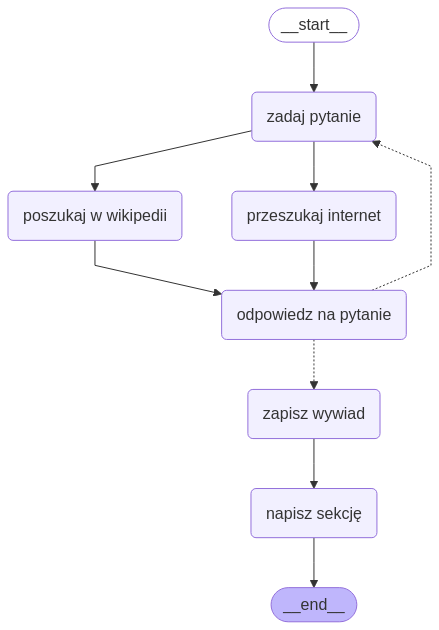

In [ ]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content="""Otrzymasz rozmowę między analitykiem a ekspertem.

Twoim celem jest wygenerowanie dobrze skonstruowanego zapytania do wykorzystania w wyszukiwaniu i/lub przeszukiwaniu stron internetowych związanych z rozmową.

Najpierw przeanalizuj całą rozmowę.

Zwróć szczególną uwagę na ostatnie pytanie zadane przez analityka.

Przekształć to końcowe pytanie w dobrze skonstruowane zapytanie wyszukiwania w Internecie""")

def search_web(state: InterviewState):

    """ Wyszukaj dokumenty w internecie """

    print("... ", analyst.role, ": Przeszukuję Internet ...")

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Wyszukaj dokumenty w Wikipedii """

    print("... ", analyst.role, ": Przeszukuję Wikipedię ...")

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """Jesteś ekspertem, z którym rozmawia analityk.

Oto obszar zainteresowania analityka: {goals}.

Twoim celem jest udzielenie odpowiedzi na pytanie zadane przez ankietera.

Aby odpowiedzieć na pytanie, użyj tego kontekstu:

{context}.

Odpowiadając na pytania, postępuj zgodnie z poniższymi wskazówkami:

1. Używaj tylko informacji podanych w kontekście.

2. Nie wprowadzaj informacji zewnętrznych ani nie przyjmuj założeń wykraczających poza to, co zostało wyraźnie określone w kontekście.

3. Kontekst zawiera źródła na temat każdego dokumentu.

4. Dołącz te źródła do odpowiedzi obok odpowiednich stwierdzeń. Na przykład dla źródła nr 1 użyj [1].

5. Wymień źródła w kolejności na dole odpowiedzi. [1] Źródło 1, [2] Źródło 2 itd.

6. Jeśli źródłem jest: <Document source=„assistant/docs/llama3_1.pdf” page=„7”/>' wtedy po prostu wymień:

[1] assistant/docs/llama3_1.pdf, strona 7

I pomiń dodawanie nawiasów, a także preambuły źródła dokumentu w cytacie."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    print("... ", analyst.role, ": Generuję odpowiedzi ...")

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Przełącza pomiędzy pytaniami i odpowiedziami """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'zapisz wywiad'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Dziękuję bardzo za pomoc" in last_question.content:
        return 'zapisz wywiad'
    return "zadaj pytanie"

section_writer_instructions = """Jesteś ekspertem w pisaniu tekstów technicznych.

Twoim zadaniem jest stworzenie krótkiej, łatwo przyswajalnej sekcji raportu na podstawie zestawu dokumentów źródłowych.

1. Przeanalizuj zawartość dokumentów źródłowych:
- Nazwa każdego dokumentu źródłowego znajduje się na początku dokumentu, ze znacznikiem <Document>.

2. Utwórz strukturę raportu przy użyciu formatowania markdown:
- Użyj ## dla tytułu sekcji
- Użyj ### dla nagłówków podsekcji

3. Napisz raport zgodnie z tą strukturą:
a. Tytuł (## header)
b. Podsumowanie (### header)
c. Źródła (### header)

4. Nadaj tytułowi angażujący charakter w oparciu o obszar zainteresowania analityka:
{focus}

5. Sekcja podsumowania:
- Skonfiguruj podsumowanie z ogólnym tłem / kontekstem związanym z obszarem zainteresowania analityka.
- Podkreśl, co jest nowego, interesującego lub zaskakującego w spostrzeżeniach zebranych podczas wywiadu.
- Utwórz ponumerowaną listę dokumentów źródłowych, gdy ich używasz.
- Nie wymieniaj nazwisk ankieterów ani ekspertów.
- Maksymalnie około 400 słów
- Użyj numerowanych źródeł w raporcie (np. [1], [2]) w oparciu o informacje z dokumentów źródłowych.

6. W sekcji Źródła:
- Uwzględnij wszystkie źródła wykorzystane w raporcie
- Podaj pełne linki do odpowiednich stron internetowych lub określonych ścieżek dokumentów
- Oddziel każde źródło nową linią. Użyj dwóch spacji na końcu każdego wiersza, aby utworzyć nową linię w Markdown.
- Będzie to wyglądać następująco:

### Źródła
[1] Nazwa linku lub dokumentu
[2] Link lub nazwa dokumentu

7. Upewnij się, że źródła są połączone. Na przykład nie jest to poprawne:

[3] https://ai.meta.com/b"""

def write_section(state: InterviewState):

    """ Węzeł udzielający odpowiedzi """

    # Wczytaj stan
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    print("... ", analyst.role, ": Piszę sekcję ...")

    # Napisz sekcję, korzystając z zebranych dokumentów źródłowych z wywiadu (context) lub samego wywiadu (interview).
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Wykorzystaj to źródło do napisania tej sekcji: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("zadaj pytanie", generate_question)
interview_builder.add_node("przeszukaj internet", search_web)
interview_builder.add_node("poszukaj w wikipedii", search_wikipedia)
interview_builder.add_node("odpowiedz na pytanie", generate_answer)
interview_builder.add_node("zapisz wywiad", save_interview)
interview_builder.add_node("napisz sekcję", write_section)

# Flow
interview_builder.add_edge(START, "zadaj pytanie")
interview_builder.add_edge("zadaj pytanie", "przeszukaj internet")
interview_builder.add_edge("zadaj pytanie", "poszukaj w wikipedii")
interview_builder.add_edge("przeszukaj internet", "odpowiedz na pytanie")
interview_builder.add_edge("poszukaj w wikipedii", "odpowiedz na pytanie")
interview_builder.add_conditional_edges("odpowiedz na pytanie", route_messages,['zadaj pytanie','zapisz wywiad'])
interview_builder.add_edge("zapisz wywiad", "napisz sekcję")
interview_builder.add_edge("napisz sekcję", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Przeprowadź wywiady")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [17]:
# Wypróbujmy na razie tylko jednego analityka
analysts[0]

Analyst(affiliation='Bank XYZ', name='Anna Kowalska', role='Ekspert ds. zastosowań systemów wielo-agentowych', description='Specjalizuje się w implementacji systemów opartych na sztucznej inteligencji w sektorze finansowym. Posiada doświadczenie w projektach związanych z automatyzacją procesów bankowych oraz analizą danych.')

In [18]:
from IPython.display import Markdown
messages = [HumanMessage(f"Mówisz więc, że piszesz artykuł na temat {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

... Generuję pytania do wywiadu ...
...  Analityk trendów rynkowych : Przeszukuję Wikipedię ...
...  Analityk trendów rynkowych : Przeszukuję Internet ...
...  Ekspert ds. zastosowań systemów wielo-agentowych : Generuję odpowiedzi ...
... Generuję pytania do wywiadu ...
... ...  Analityk trendów rynkowych : Przeszukuję Internet ...
 Analityk trendów rynkowych : Przeszukuję Wikipedię ...
...  Ekspert ds. zastosowań systemów wielo-agentowych : Generuję odpowiedzi ...
...  Ekspert ds. zastosowań systemów wielo-agentowych : Piszę sekcję ...


## Rewolucja w Bankowości: Jak Cyfrowe Bliźniaki i AI Zmieniają Sektor Finansowy

### Podsumowanie
W ostatnich latach technologia cyfrowych bliźniaków oraz duże modele językowe (LLM) zyskały na znaczeniu w sektorze bankowym, przekształcając sposób, w jaki instytucje finansowe zarządzają swoimi operacjami. Cyfrowe bliźniaki, będące wirtualnymi replikami rzeczywistych obiektów i procesów, umożliwiają bankom optymalizację działań oraz lepsze przewidywanie trendów rynkowych. Integracja LLM z cyfrowymi bliźniakami zwiększa zdolność do przetwarzania i generowania języka naturalnego, co z kolei poprawia interakcje z klientami oraz automatyzację zadań [1].

Zaskakujące jest, że według badań Accenture, aż 73% czasu pracy w bankowości może zostać zautomatyzowane dzięki nowym technologiom, co czyni ten sektor liderem wśród różnych branż [2]. Warto również zauważyć, że LLM nie tylko wspierają automatyzację, ale także wzbogacają doświadczenia klientów poprzez personalizację usług i rekomendacji [3]. Przykłady zastosowań obejmują automatyczne sporządzanie notatek przez systemy wspierające obsługę klienta, co pozwala pracownikom skupić się na bardziej złożonych zadaniach [4].

1. Cyfrowe bliźniaki z LLM poprawiają interakcje i automatyzację.
2. W bankowości 73% pracy może być zautomatyzowane.
3. LLM wspierają personalizację usług, co zwiększa zadowolenie klientów.

### Źródła
[1] https://www.galaksiya.com/pl/articles/twinize-digital-twin-technology-in-banking  
[2] https://itwiz.pl/3-obszary-na-ktore-wplynie-generatywna-ai-w-bankowosci/  
[3] https://botpress.com/pl/blog/best-large-language-models/  
[4] https://action.bot/pl/blog/duze-modele-jezykowe-llm/  

### Map-Reduce: przeprowadzenie wielu analiz równolegle

Zrównoleglimy teraz wywiady za pomocą interfejsu API `Send()` (etap Map).

Na koniec połączymy je w treść raportu w kroku Reduce, po czym napiszemy wstęp i zakończenie raportu końcowego.

In [19]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


class ResearchGraphState(TypedDict):
    topic: str # Temat badawczy
    max_analysts: int # Maksymalna liczba analityków
    human_analyst_feedback: str # Opinia użytkownika
    analysts: List[Analyst] # Analityk zadający pytanie
    sections: Annotated[list, operator.add] # Klucz do Send() API
    introduction: str # Wprowadzenie do raportu końcowego
    content: str # Zawartość raportu końcowego
    conclusion: str # Konkluzja raportu końcowego
    final_report: str # Raport końcowy

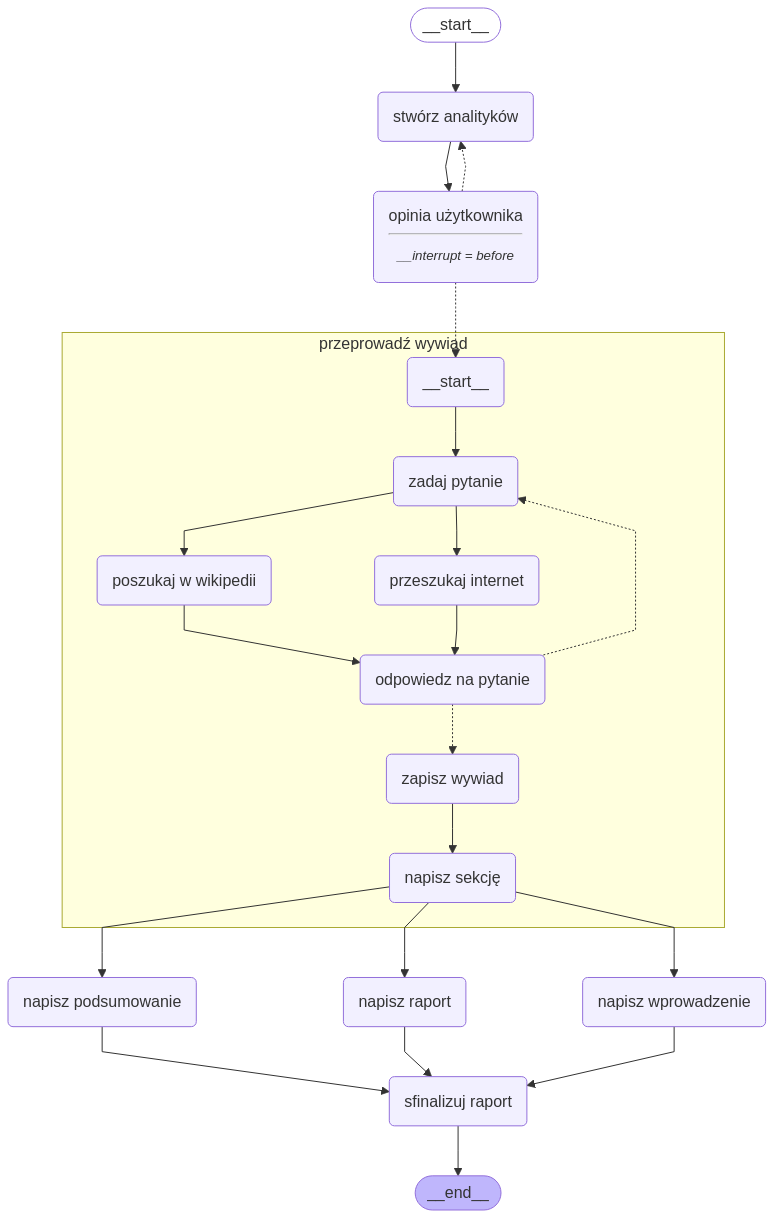

In [20]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ Jest to krok „mapowania”, w którym uruchamiamy każdy podgraf wywiadu za pomocą Send API """
    print("... Inicjuję wywiady ...")
    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "stwórz analityków"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("przeprowadź wywiad", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"Mówisz więc, że piszesz artykuł na temat {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """Jesteś specjalistą technicznym tworzącym raport na poniższy temat:

{topic}

Masz zespół analityków. Każdy analityk wykonał dwie czynności:

1. Przeprowadził wywiad z ekspertem na określony temat cząstkowy.
2. Zapisał swoje ustalenia w notatce.

Twoje zadanie:

1. Otrzymasz zbiór notatek od swoich analityków.
2. Zastanów się dokładnie nad wnioskami z każdej notatki.
3. Skonsoliduj je w ogólne, zwięzłe podsumowanie, które integruje główne pomysły ze wszystkich notatek.
4. Podsumuj główne punkty każdej notatki w spójną, pojedynczą narrację.

Aby sformatować raport:

1. Użyj formatowania markdown.
2. Nie dołączaj wstępu do raportu.
3. Nie używaj podtytułów.
4. Rozpocznij raport od pojedynczego nagłówka tytułowego: ## Główne wnioski
5. W raporcie nie wymieniaj imion i nazwisk analityków.
6. Zachowaj wszelkie cytaty w notatkach, które zostaną oznaczone w nawiasach, na przykład [1] lub [2].
7. Utwórz ostateczną, skonsolidowaną listę źródeł i dodaj ją do sekcji Źródła z nagłówkiem `## Źródła`.
8. Wymień źródła w kolejności i nie powtarzaj ich.

[1] Źródło 1
[2] Źródło 2

Oto notatki od analityków, na podstawie których można zbudować raport:

{context}"""

def write_report(state: ResearchGraphState):
    print("... Piszę raport ...")
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Napisz raport w oparciu o te notatki.")])
    return {"content": report.content}

intro_conclusion_instructions = """Jesteś specjalistą technicznym kończącym raport na temat {topic}.

Otrzymasz wszystkie sekcje raportu.

Twoim zadaniem jest napisanie wyrazistego i przekonującego wstępu lub zakończenia.

Użytkownik poinstruuje Cię, czy napisać wstęp czy zakończenie.

Nie dołączaj wstępu do żadnej z sekcji.

Celuj w około 100 słów, zwięzły przegląd zagadnień (w przypadku wstępu) lub podsumowanie (w przypadku podsumowania) wszystkich sekcji raportu.

Użyj formatowania markdown.

W przypadku wstępu utwórz atrakcyjny tytuł i użyj nagłówka # dla tytułu.

W przypadku wprowadzenia użyj ## Wprowadzenie jako nagłówka sekcji.

W podsumowaniu użyj ## Podsumowanie jako nagłówka sekcji.

Oto sekcje, nad którymi należy się zastanowić podczas pisania: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    print("... Piszę wprowadzenie...")
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Napisz wprowadzenie do raportu")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    print("... Piszę podsumowanie ...")
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Napisz podsumowanie raportu")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ Jest to etap „reduce”, w którym zbieramy wszystkie sekcje, łączymy je i zastanawiamy się nad nimi, aby napisać wstęp / zakończenie """
    print("... Finalizuję raport ...")
    # Save full final report
    content = state["content"]
    if content.startswith("## Wnioski"):
        content = content.strip("## Wnioski")
    if "## Źródła" in content:
        try:
            content, sources = content.split("\n## Źródła\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Źródła\n" + sources
    return {"final_report": final_report}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Przełącza pomiędzy pytaniami i odpowiedziami """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'zapisz wywiad'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Dziękuję bardzo za pomoc" in last_question.content:
        return 'zapisz wywiad'
    return "zadaj pytanie"

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("zadaj pytanie", generate_question)
interview_builder.add_node("przeszukaj internet", search_web)
interview_builder.add_node("poszukaj w wikipedii", search_wikipedia)
interview_builder.add_node("odpowiedz na pytanie", generate_answer)
interview_builder.add_node("zapisz wywiad", save_interview)
interview_builder.add_node("napisz sekcję", write_section)

# Flow
interview_builder.add_edge(START, "zadaj pytanie")
interview_builder.add_edge("zadaj pytanie", "przeszukaj internet")
interview_builder.add_edge("zadaj pytanie", "poszukaj w wikipedii")
interview_builder.add_edge("przeszukaj internet", "odpowiedz na pytanie")
interview_builder.add_edge("poszukaj w wikipedii", "odpowiedz na pytanie")
interview_builder.add_conditional_edges("odpowiedz na pytanie", route_messages,['zadaj pytanie','zapisz wywiad'])
interview_builder.add_edge("zapisz wywiad", "napisz sekcję")
interview_builder.add_edge("napisz sekcję", END)


# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("stwórz analityków", create_analysts)
builder.add_node("opinia użytkownika", human_feedback)
builder.add_node("przeprowadź wywiad", interview_builder.compile())
builder.add_node("napisz raport",write_report)
builder.add_node("napisz wprowadzenie",write_introduction)
builder.add_node("napisz podsumowanie",write_conclusion)
builder.add_node("sfinalizuj raport",finalize_report)

# Logic
builder.add_edge(START, "stwórz analityków")
builder.add_edge("stwórz analityków", "opinia użytkownika")
builder.add_conditional_edges("opinia użytkownika", initiate_all_interviews, ["stwórz analityków", "przeprowadź wywiad"])
builder.add_edge("przeprowadź wywiad", "napisz raport")
builder.add_edge("przeprowadź wywiad", "napisz wprowadzenie")
builder.add_edge("przeprowadź wywiad", "napisz podsumowanie")
builder.add_edge(["napisz podsumowanie", "napisz raport", "napisz wprowadzenie"], "sfinalizuj raport")
builder.add_edge("sfinalizuj raport", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['opinia użytkownika'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Zadajmy teraz nasze pytanie

In [21]:
# Inputs
max_analysts = 3
topic = "Jaki jest potencjał zastosowań systemów wielo-agentowych opartych na dużych modelach językowych w bankowości?"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Imię i nazwisko: {analyst.name}")
            print(f"Afiliacja: {analyst.affiliation}")
            print(f"Rola: {analyst.role}")
            print(f"Opis: {analyst.description}")
            print("-" * 50)

... Tworzę zespół analityków ...
Imię i nazwisko: Anna Kowalska
Afiliacja: Bank XYZ
Rola: Ekspert ds. systemów wielo-agentowych
Opis: Specjalizuje się w zastosowaniach systemów wielo-agentowych w finansach, z doświadczeniem w implementacji rozwiązań opartych na sztucznej inteligencji. Zmotywowana do badania, jak duże modele językowe mogą wspierać procesy decyzyjne w bankowości.
--------------------------------------------------
Imię i nazwisko: Marek Nowak
Afiliacja: Instytut Badań Finansowych
Rola: Analityk danych
Opis: Posiada doświadczenie w analizie danych w sektorze bankowym, ze szczególnym uwzględnieniem analizy ryzyka. Zainteresowany wykorzystaniem dużych modeli językowych do analizy sentymentu klientów oraz prognozowania trendów rynkowych.
--------------------------------------------------
Imię i nazwisko: Katarzyna Wiśniewska
Afiliacja: Uniwersytet Ekonomiczny
Rola: Badaczka innowacji technologicznych
Opis: Zajmuje się badaniami nad innowacjami w bankowości, ze szczególnym nac

In [22]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Dodaj specjalistę ds ochrony danych osobowych"}, as_node="opinia użytkownika")

... Inicjuję wywiady ...


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01f656-84eb-63bf-8002-d4a7a2ca1fb5'}}

In [23]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Imię: {analyst.name}")
            print(f"Afiliacja: {analyst.affiliation}")
            print(f"Rola: {analyst.role}")
            print(f"Opis: {analyst.description}")
            print("-" * 50)

Imię: Anna Kowalska
Afiliacja: Bank XYZ
Rola: Ekspert ds. systemów wielo-agentowych
Opis: Specjalizuje się w zastosowaniach systemów wielo-agentowych w finansach, z doświadczeniem w implementacji rozwiązań opartych na sztucznej inteligencji. Zmotywowana do badania, jak duże modele językowe mogą wspierać procesy decyzyjne w bankowości.
--------------------------------------------------
Imię: Marek Nowak
Afiliacja: Instytut Badań Finansowych
Rola: Analityk danych
Opis: Posiada doświadczenie w analizie danych w sektorze bankowym, ze szczególnym uwzględnieniem analizy ryzyka. Zainteresowany wykorzystaniem dużych modeli językowych do analizy sentymentu klientów oraz prognozowania trendów rynkowych.
--------------------------------------------------
Imię: Katarzyna Wiśniewska
Afiliacja: Uniwersytet Ekonomiczny
Rola: Badaczka innowacji technologicznych
Opis: Zajmuje się badaniami nad innowacjami w bankowości, ze szczególnym naciskiem na technologie oparte na AI. Zmotywowana do zbadania, jak s

In [24]:
# Potwierdź, że jest OK
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="opinia użytkownika")

... Inicjuję wywiady ...


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01f656-c3c0-657c-8004-b8fdefe88851'}}

In [25]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    node_name = next(iter(event.keys()))

... Generuję pytania do wywiadu ...... Generuję pytania do wywiadu ...
... Generuję pytania do wywiadu ...

... ...  Analityk rynku finansowego : Przeszukuję Internet ...
 Analityk rynku finansowego : Przeszukuję Wikipedię ...
...  Analityk rynku finansowego : Przeszukuję Wikipedię ...
...  Analityk rynku finansowego : Przeszukuję Internet ...
...  Analityk rynku finansowego : Przeszukuję Wikipedię ...
...  Analityk rynku finansowego : Przeszukuję Internet ...
...  Specjalista ds. ochrony danych osobowych : Generuję odpowiedzi ...
...  Analityk ds. zastosowań AI w bankowości : Generuję odpowiedzi ...
...  Analityk rynku finansowego : Generuję odpowiedzi ...
... Generuję pytania do wywiadu ...
... Generuję pytania do wywiadu ...
...  Analityk rynku finansowego : Przeszukuję Wikipedię ...
...  Analityk rynku finansowego : Przeszukuję Internet ...
...  Analityk rynku finansowego : Przeszukuję Wikipedię ...
...  Analityk rynku finansowego : Przeszukuję Internet ...
... Generuję pytania do 

In [27]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Potencjał Zastosowań Systemów Wielo-Agentowych w Bankowości

## Wprowadzenie

Sektor bankowy stoi na progu rewolucji technologicznej, w której sztuczna inteligencja (AI) i uczenie maszynowe (ML) odgrywają kluczową rolę. W szczególności, integracja dużych modeli językowych (LLM) z systemami wielo-agentowymi oraz technologią cyfrowych bliźniaków otwiera nowe horyzonty w zakresie optymalizacji operacji, poprawy interakcji z klientami oraz zwiększenia bezpieczeństwa danych. W niniejszym raporcie przyjrzymy się innowacyjnym zastosowaniom tych technologii w bankowości, analizując ich wpływ na efektywność procesów, automatyzację zadań oraz personalizację usług. Zrozumienie potencjału tych rozwiązań jest kluczowe dla instytucji finansowych, które pragną utrzymać konkurencyjność w dynamicznie zmieniającym się środowisku rynkowym.

---

## Główne wnioski

Sektor bankowy przechodzi dynamiczną transformację dzięki integracji sztucznej inteligencji (AI) oraz uczenia maszynowego (ML), w szczególności poprzez zastosowanie technologii cyfrowych bliźniaków wspieranych przez duże modele językowe (LLM). Cyfrowe bliźniaki, będące wirtualnymi replikami fizycznych obiektów, umożliwiają bankom symulację zachowań klientów oraz analizę trendów rynkowych w czasie rzeczywistym, co prowadzi do lepszego zarządzania operacjami i zwiększenia satysfakcji klientów [1]. 

Z badań wynika, że aż 73% czasu pracy w bankowości może zostać zautomatyzowane dzięki generatywnej AI, co czyni ten sektor jednym z najbardziej podatnych na transformację technologiczną [2]. Warto również zauważyć, że 39% pracy w bankach ma wysoki potencjał do automatyzacji, co otwiera nowe możliwości dla pracowników, którzy mogą skupić się na bardziej złożonych zadaniach [2]. Przykłady zastosowania LLM obejmują wsparcie przedstawicieli obsługi klienta, gdzie modele automatycznie generują notatki i dostarczają istotne informacje, co zwiększa efektywność interakcji z klientami [2].

Integracja LLM z systemami wieloagentowymi oraz grafami wiedzy pozwala na tworzenie bardziej inteligentnych i responsywnych cyfrowych bliźniaków, co może zrewolucjonizować sposób, w jaki banki prowadzą swoje operacje [1]. Systemy wieloagentowe, wprowadzające wyspecjalizowanych agentów do zarządzania operacjami bankowymi, mogą przyczynić się do zwiększenia efektywności i bezpieczeństwa danych, jednak niosą ze sobą również ryzyko związane z nieautoryzowanym dostępem do informacji [4]. 

W kontekście bezpieczeństwa, banki wprowadzają różnorodne środki ochronne, takie jak silne hasła i zabezpieczenia przed atakami hakerskimi, które są coraz bardziej złożone i ewoluują w miarę rozwoju technologii [3]. Cyfrowe bliźniaki mogą symulować zachowania klientów oraz trendy rynkowe, co umożliwia bankom lepsze prognozowanie i dostosowywanie ofert do potrzeb rynku [3]. 

Podsumowując, integracja cyfrowych bliźniaków, LLM oraz systemów wieloagentowych w bankowości nie tylko zwiększa wydajność, ale także umożliwia tworzenie spersonalizowanych usług dla klientów, co jest kluczowe w dzisiejszym konkurencyjnym środowisku.


---

## Podsumowanie

Sektor bankowy stoi na progu rewolucji dzięki integracji sztucznej inteligencji i dużych modeli językowych (LLM) z technologią cyfrowych bliźniaków. Te innowacyjne rozwiązania umożliwiają bankom optymalizację operacji, poprawę interakcji z klientami oraz zwiększenie efektywności procesów. Badania wskazują, że aż 73% pracy w bankowości może zostać zautomatyzowane, co otwiera nowe możliwości dla pracowników i instytucji. Cyfrowe bliźniaki, wspierane przez systemy wieloagentowe, pozwalają na lepsze prognozowanie trendów rynkowych oraz personalizację usług, co jest kluczowe w dzisiejszym konkurencyjnym środowisku. Warto jednak pamiętać o wyzwaniach związanych z bezpieczeństwem danych, które wymagają ciągłej uwagi i innowacyjnych rozwiązań.

## Źródła
[1] https://www.galaksiya.com/pl/articles/twinize-digital-twin-technology-in-banking/  
[2] https://itwiz.pl/3-obszary-na-ktore-wplynie-generatywna-ai-w-bankowosci/  
[3] https://gomobi.pl/blogi/przyklady-zastosowania-sztucznej-inteligencji-ai-oraz-uczenia-maszynowego-w-bankowosci/  
[4] https://bankiwpolsce.pl/aktualne-zagrozenia-dla-uzytkownikow-bankowosci-elektronicznej  